In [1]:
from multiprocessing import Pool
from tqdm import tqdm_notebook, tqdm
import random
import json

import numpy as np
import pandas as pd
import gc

In [311]:
#path = 'C:/Users/zhangmen/Downloads/QA_Google/data'
path = '/Users/Mengying/Desktop/QA_Google/data/'
train_path = 'simplified-nq-train.jsonl'
test_path = 'simplified-nq-test.jsonl'
sample_submission_path = 'sample_submission.csv'

def read_data(path, sample = True, chunksize = 307373): # 307373
    if sample == True:
        df = []

        with open(path, 'rt') as reader:
            for i in tqdm(range(chunksize), position=0, leave=True):
                info = json.loads(reader.readline())
                #if info['annotations'][0]['yes_no_answer'] != 'NONE':
                df.append(info)
                                
        df = pd.DataFrame(df)
       
        print('Our sampled dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = pd.read_json(path, orient = 'records', lines = True,dtype = {'example_id':'int64'}).set_index('example_id')
        #reset index
        df.reset_index(level=0, inplace=True)
        print('Our dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
        gc.collect()
    return df

train = read_data(path+train_path, sample = True,chunksize =60000 ) # first 60k
#train = read_data(path+train_path, sample = True) # first 500k
#dev = read_data(path+train_path, sample = True,chunksize =1000 ) # first 10k
#test = read_data(path+test_path, sample = False)
#train.head()
#print(train.columns)

100%|██████████| 60000/60000 [01:27<00:00, 686.70it/s] 


Our sampled dataset have 60000 rows and 6 columns


In [30]:
# read in processed short version
#train = pd.read_csv(path+"long_df_30kobs.csv")

In [295]:
train.head(1)

,annotations,document_text,document_url,example_id,long_answer_candidates,question_text
0,"[{'yes_no_answer': 'YES', 'long_answer': {'sta...",Berlin Station ( TV series ) - wikipedia <H1> ...,https://en.wikipedia.org//w/index.php?title=Be...,8609375096218900192,"[{'start_token': 16, 'top_level': True, 'end_t...",is there a season 3 of berlin station


In [5]:
train.iloc[0,:]

document_text             Email marketing - Wikipedia <H1> Email marketi...
long_answer_candidates    [{'start_token': 14, 'top_level': True, 'end_t...
question_text             which is the most common use of opt-in e-mail ...
annotations               [{'yes_no_answer': 'NONE', 'long_answer': {'st...
document_url              https://en.wikipedia.org//w/index.php?title=Em...
example_id                                              5655493461695504401
Name: 0, dtype: object

In [9]:
# Missing value investigation
def missing_values(df):
    df = pd.DataFrame(df.isnull().sum()).reset_index()
    df.columns = ['features', 'n_missing_values']
    return df
missing_values(train)

,features,n_missing_values
0,document_text,0
1,long_answer_candidates,0
2,question_text,0
3,annotations,0
4,document_url,0
5,example_id,0


### Prepare a clean dataset(for long answer only)
Each row is a paragraph and a question and an answer match, with 1 indicating True, 0 indicating False.

In [10]:
COLUMNS_LONG = ["paragraph","question","is_answer","example_id"]

In [116]:
def process_df_for_long(df, train=1):
    # train: 1 for train, 2 for dev, 3 for test
    def process_row(row):
        ids = row.example_id
        q = row.question_text
        p = row.document_text.split()
        
        if train==1 or train == 2:
            long_answer_dict = row.annotations[0]['long_answer']
            answer_text = " ".join(p[long_answer_dict['start_token']:long_answer_dict['end_token']])

            if answer_text == "":  # no long answer
                rows_to_add = []
            else:
                rows_to_add = [[answer_text, q, 1, ids]]
        else:
            rows_to_add = []
        
        candidates_dict_list = row.long_answer_candidates
        
        # train=1: only add negative example limit times for those with answer only
        # train=2: add negative example limit times for all articles
        # train=3: add all candidates
        if (train == 1 and rows_to_add) or train == 2 or train == 3:
            random.shuffle(candidates_dict_list)
            if train == 1 or train == 2:
                limit = 2                
            else:
                limit = len(candidates_dict_list)
            
            neg = 0

            for i in candidates_dict_list:
                if (train == 1 or train == 2) and i['start_token'] == long_answer_dict['start_token'] and i['end_token'] == long_answer_dict['end_token']: continue
                candidate_text = " ".join(p[i['start_token']:i['end_token']])
                if train == 3:
                    rows_to_add.append([candidate_text, q, "{}:{}".format(i['start_token'],i['end_token']), ids])
                else:
                    rows_to_add.append([candidate_text, q, 0, ids])
                neg += 1
                if neg == limit: break



        temp_df = pd.DataFrame(rows_to_add,columns=COLUMNS_LONG)
        return temp_df
    
    temp_df_list = []
    for _, row in df.iterrows():
        temp_df_list.append(process_row(row))
        
    
    # concatenate all at the very end
    return pd.concat(temp_df_list,ignore_index=True)   

In [67]:
# read in parallize form
# def parallelize_dataframe(df, func, n_cores=2):
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

# long_df = parallelize_dataframe(train, process_df_for_long)
# print("long_df dimension: ", long_df.shape )

random.seed(9001)
long_df = process_df_for_long(train)
print("long_df dimension: ", long_df.shape )

long_df dimension:  (44821, 4)


In [16]:
long_df.head(10)

,paragraph,question,is_answer,example_id
0,<P> A common example of permission marketing i...,which is the most common use of opt-in e-mail ...,1,5655493461695504401
1,<P> There are both advantages and disadvantage...,which is the most common use of opt-in e-mail ...,0,5655493461695504401
2,<P> Email marketing is popular with companies ...,which is the most common use of opt-in e-mail ...,0,5655493461695504401
3,"<P> Tracy McConnell , better known as `` The M...",how i.met your mother who is the mother,1,5328212470870865242
4,"<P> Some time after this , a man named Darren ...",how i.met your mother who is the mother,0,5328212470870865242
5,<P> The story of how Ted met The Mother is the...,how i.met your mother who is the mother,0,5328212470870865242
6,<P> The process of fertilization involves a sp...,what type of fertilisation takes place in humans,1,4435104480114867852
7,<P> The fusion of cell membranes of the second...,what type of fertilisation takes place in humans,0,4435104480114867852
8,<Tr> <Td> Part of a series on </Td> </Tr>,what type of fertilisation takes place in humans,0,4435104480114867852
9,<P> Active quarterback Tom Brady holds the rec...,who had the most wins in the nfl,1,5289242154789678439


In [25]:
# inspect a pair of question and answer
long_df[(long_df.example_id==3668384117542638462) & (long_df.is_answer==1)].iloc[0,0]

"<P> After searching all day , Chandler hurries back to his apartment and when he gets there , Joey meets him in the hall , claiming Monica has left him because of his commitment issues . When Chandler enters their apartment , afraid of Monica actually leaving , he discovers that it 's far from being abandoned , there are candles lit all over and Monica is kneeling to propose . In the midst of proposing to Chandler , she cries from sheer emotion , saying , `` There 's a reason why girls do n't do this ! '' Instead , Chandler gets on his knees and proposes to her and Monica says yes . They then open the door to Joey , Rachel , and Phoebe , who have been waiting to celebrate . At first , they hesitate , feeling Ross should be there to share the moment , then decide that after three marriages , Ross can afford to miss one engagement celebration . End credits play while Monica and Chandler dance to Eric Clapton 's `` Wonderful Tonight . '' </P>"

In [21]:
long_df[(long_df.example_id==3668384117542638462) & (long_df.is_answer==1)].iloc[0,1]

'the one where chandler and monica get engaged'

In [69]:
# save dataset
long_df.to_csv(path+"long_df_30kobs.csv",index=False)

### For dev data to tune cut-off threshold:

In [99]:
#long_df_test = pd.read_csv(path+"long_df_dev.csv")

In [108]:
random.seed(911)
long_df = process_df_for_long(dev, train=2)
print("long_df dimension: ", long_df.shape )

long_df dimension:  (2514, 4)


In [110]:
# save dataset
long_df.to_csv(path+"long_df_dev.csv",index=False)

In [ ]:
### Prediction on GCP ####

In [153]:
long_df = pd.read_csv(path+"long_df_dev_pred.csv")

In [158]:
long_df.head(2)

,paragraph,question,is_answer,example_id,pred
0,<P> A common example of permission marketing i...,which is the most common use of opt-in e-mail ...,1,5655493461695504401,0.186052
1,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,which is the most common use of opt-in e-mail ...,0,5655493461695504401,0.505924


In [160]:
long_df[long_df.is_answer==1].pred.describe()

count    516.000000
mean       0.761145
std        0.272641
min        0.004727
25%        0.634844
50%        0.889815
75%        0.967593
max        0.989851
Name: pred, dtype: float64

In [161]:
long_df[long_df.is_answer==0].pred.describe()

count    1998.000000
mean        0.255769
std         0.342755
min         0.000982
25%         0.007687
50%         0.037923
75%         0.517315
max         0.985978
Name: pred, dtype: float64

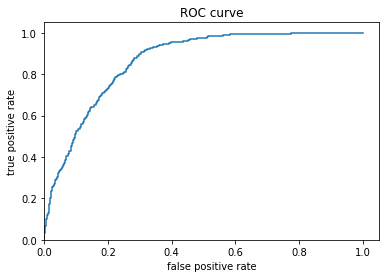

In [163]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
fpr, tpr, _ = roc_curve(long_df.is_answer, long_df.pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [165]:
# Find optimal threshold that maximizes accuracy:
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point



optimal cutoff threshold is: [0.59765285]


### For submission file:

In [114]:
test.head(1)

,example_id,document_text,long_answer_candidates,question_text
0,-1220107454853145579,"High Commission of South Africa , London - wik...","[{'end_token': 136, 'start_token': 18, 'top_le...",who is the south african high commissioner in ...


In [126]:
# for test:
random.seed(9001)
long_df_test = process_df_for_long(test, train=3)
print("long_df dimension: ", long_df_test.shape ) 
# Note: originally we can have (45163, 4), which takes too long for prediction. 
# > Use bi-gram overlap score to minimize prediction pairs.

long_df dimension:  (45163, 4)


In [127]:
# to make consistent, rename the column name
long_df_test['PredictionString']= long_df_test['is_answer']
long_df_test['is_answer'] = 0

In [166]:
len(long_df_test.example_id.unique())

346

In [130]:
# only pass those pairs whose bi-gram overlap > 0
def find_bigrams(row):
    p = row.paragraph.lower().split()
    q = row.question.lower().split()
    p_bigram = set(zip(p, p[1:]))
    q_bigram = set(zip(q, q[1:]))
    return len(p_bigram.intersection(q_bigram)) # output bigram overlap score
    

long_df_test['bigrams'] = long_df_test.apply(lambda row: find_bigrams(row),axis=1)

long_df_test_yes = long_df_test[long_df_test.bigrams > 0]
#print("long_df_test dimension: ", long_df_test.shape )

In [135]:
len(long_df_test_yes.example_id.unique()) # 346 - 334 = 12 articles do not have overlap bigrams

334

In [139]:
yes = long_df_test_yes.example_id.unique()

In [142]:
special = long_df_test[~(long_df_test.example_id.isin(yes))]

In [152]:
special[special.example_id == -66688804835093544].iloc[5,1]

'where does barbacoa come from on a cow'

In [151]:
special[special.example_id == -66688804835093544].iloc[5,0]

'<P> In the U.S. , barbacoa is often prepared with parts from the heads of cattle , such as the cheeks . In northern Mexico , it is also sometimes made from beef head , but more often it is prepared from goat meat ( cabrito ) . In central Mexico , the meat of choice is lamb , and in the Yucatan , their traditional version , cochinita pibil ( pit - style pork ) , is prepared with pork . </P>'

In [125]:
# ind = 3
# p = long_df_test.iloc[ind,0].lower().split()
# q = long_df_test.iloc[ind,1].lower().split()
# p_bigram = set(zip(p, p[1:]))
# q_bigram = set(zip(q, q[1:]))

# print(p_bigram.intersection(q_bigram))
len(long_df_test.example_id.unique()) # 346 - 334 = 12 articles do not have overlap bigrams

343

In [171]:
long_df_test.loc[long_df_test.example_id == -1220107454853145579]

,paragraph,question,is_answer,example_id,PredictionString,bigrams
0,"<Table> <Tr> <Th_colspan=""2""> High Commission ...",who is the south african high commissioner in ...,0,-1220107454853145579,18:136,2
1,"<P> South Africa House was built by Holland , ...",who is the south african high commissioner in ...,0,-1220107454853145579,240:336,0
2,<Tr> <Th> High Commissioner </Th> <Td> Vacant ...,who is the south african high commissioner in ...,0,-1220107454853145579,126:135,1
3,<Tr> <Th> Address </Th> <Td> Trafalgar Square ...,who is the south african high commissioner in ...,0,-1220107454853145579,45:59,0
4,<P> The first fully free democratic elections ...,who is the south african high commissioner in ...,0,-1220107454853145579,425:488,0
5,<Tr> <Th> Location </Th> <Td> Trafalgar Square...,who is the south african high commissioner in ...,0,-1220107454853145579,34:45,0
6,<Tr> <Th> Coordinates </Th> <Td> 51 ° 30 ′ 30 ...,who is the south african high commissioner in ...,0,-1220107454853145579,59:126,0
7,"<Tr> <Th_colspan=""2""> High Commission of South...",who is the south african high commissioner in ...,0,-1220107454853145579,19:30,1
8,<P> The High Commission of South Africa in Lon...,who is the south african high commissioner in ...,0,-1220107454853145579,141:211,5
9,"<P> In 1961 , South Africa became a republic ,...",who is the south african high commissioner in ...,0,-1220107454853145579,336:425,1


In [97]:
# save dataset
long_df_test.to_csv(path+"long_df_submission.csv",index=False)

### Prepare a clean dataset(for short answer only)
Each row is a paragraph and a question and a short answer in text.

In [312]:
COLUMNS_SHORT = ["paragraph","question","is_answer","example_id"]

In [313]:
def process_df_for_short(df):
    def process_row(row):
        ids = row.example_id
        q = row.question_text
        p = row.document_text.split()
        

        rows_to_add = []
        short_answer_list = row.annotations[0]['short_answers']
        if len(short_answer_list) == 0:
            if row.annotations[0]['yes_no_answer'] != 'NONE':
                answer_text= row.annotations[0]['yes_no_answer']
                # short answer source paragraph:
                long_answer_dict = row.annotations[0]['long_answer']
                candidate_text = " ".join(p[long_answer_dict['start_token']:long_answer_dict['end_token']])

                rows_to_add.append([candidate_text, q, answer_text, ids])
             
        else:
            # short answer source paragraph:
            long_answer_dict = row.annotations[0]['long_answer']
            candidate_text = " ".join(p[long_answer_dict['start_token']:long_answer_dict['end_token']])

            for short_answer in short_answer_list: 
                answer_text = " ".join(p[short_answer['start_token']:short_answer['end_token']])

                rows_to_add.append([candidate_text, q, answer_text, ids])
       
        
        
        temp_df = pd.DataFrame(rows_to_add,columns=COLUMNS_SHORT)    
        return temp_df
            
    
    
    temp_df_list = []
    for _, row in df.iterrows():
        temp_df_list.append(process_row(row))
        
    
    # concatenate all at the very end
    return pd.concat(temp_df_list,ignore_index=True)   

In [235]:
short_df = process_df_for_short(train)
print("short_df dimension: ", short_df.shape )

short_df dimension:  (3050, 4)


In [6]:
short_df.head()

,paragraph,question,is_answer,example_id
0,<P> A common example of permission marketing i...,which is the most common use of opt-in e-mail ...,a newsletter sent to an advertising firm 's cu...,5655493461695504401
1,"<P> Tracy McConnell , better known as `` The M...",how i.met your mother who is the mother,Tracy McConnell,5328212470870865242
2,<P> Active quarterback Tom Brady holds the rec...,who had the most wins in the nfl,Tom Brady,5289242154789678439
3,<P> Pom Klementieff ( born 3 May 1986 ) is a F...,who played mantis guardians of the galaxy 2,Pom Klementieff,-2500044561429484630
4,"<P> In the early 1960s , the Nashville sound b...",the nashville sound brought a polished and cos...,the use of lush string arrangements with a rea...,212419696952141239


In [103]:
short_df.iloc[13263,0]

"<P> The 1941 song features lyrics by June Hershey and music by Don Swander . There were no fewer than five versions in the Billboard charts in 1942 . `` Deep in the Heart of Texas '' spent five weeks at the top of Your Hit Parade in 1942 during its twelve weeks stay . </P>"

In [7]:
short_df.to_csv(path+"short_df_60kobs.csv",index=False)

### Answer type prediction: is this a YES/NO question?

In [242]:
# first 60k + last 60k > yesno only, resulting in 1505 obs
yes_no = pd.read_csv(path+"yesno_df_1kobs.csv")

In [243]:
yes_no.shape

(1505, 4)

In [199]:
# get the first one/two words of the question
yes_no.question.str.split().str.get(0).unique() #[0:2]

array(['is', 'ok', 'do', 'xbox', 'any', 'are', 'can', 'jumanji', 'does',
       'did', 'was', 'will', 'what', 'my', 'available', 'phase', 'the',
       'dialup', 'st', 'cells', 'cohesion', 'product', 'lps', 'earth',
       'in', 'stakeholder', 'who', 'kansas', 'changes', 'has',
       'planetary', 'tonari', 'legal', 'if', 'have', 'one', 'when', 'i',
       'beri', 'apsara', 'inflation', 'a', 'according', 'hydonephrosis',
       'english', 'electroplating', 'downton', 'could', 'footnote',
       'were', 'mortal', '99', 'new', 'delphi', 'originally', '1945',
       'quantum', 'interphase', 'euromillions', 'why', 'okinawa',
       'sequence', 'victoria', 'onflict', 'italy', 'yu', '3'],
      dtype=object)

In [ ]:
# fast rule based:
start_mark = ['is','are','was','were','can','could','does','did','do','will','would','any',
              'have','has','should']


### YES/NO question

In [244]:
# using last 60k directly from short_df_60kobs.csv
yes_no.head()

,paragraph,question,is_answer,example_id
0,<P> Beauty and the Beast is a 1991 American an...,is beauty and the beast a disney movie,YES,-2478107407324283570
1,"<P> Washington ( / ˈwɒʃɪŋtən / ( listen ) ) , ...",is seattle washington the same as washington dc,NO,1875979215628203642
2,"<P> In 1952 , upon U.S. Congress approving the...",if you are born in puerto rico are you an amer...,YES,-9010340742213717410
3,<P> Alpha Centauri is the name given to what a...,can you see alpha centauri without a telescope,YES,3892799676719974073
4,"<P> She attended Marymount High School , a Rom...",have any of the kardashians graduated from col...,YES,2143141820387949174


In [237]:
# using first 500k read from early cells
short_df = process_df_for_short(train)
print("short_df dimension: ", short_df.shape )

yes_no_half = short_df.loc[(short_df.is_answer == "NO") | (short_df.is_answer == "YES")]  
yes_no_half.shape

(3050, 4)

In [245]:
yes_no_half.head()

,paragraph,question,is_answer,example_id
0,<P> A ten - episode first season premiered on ...,is there a season 3 of berlin station,YES,8609375096218900192
1,"<P> In the United States , most states give th...",do inmates on death row get a last meal,YES,8373555261004214536
2,<P> Me Before You is a romance novel written b...,is me before you a nicholas sparks movie,NO,-8152629601596147239
3,"<P> During a divination session , the shell or...",oracle bones were used by the chinese to tell ...,YES,5263528727398180840
4,<Table> <Tr> <Th> Rank </Th> <Th> Company </Th...,is axa the biggest insurance company in the world,YES,-6045284519928297723


In [246]:
yes_no_all = yes_no_half.append(yes_no)

In [247]:
yes_no_all.shape

(4555, 4)

In [248]:
yes_no_all.to_csv(path+"yesno_df_4kobs.csv",index=False)

### Playground

In [318]:
ind = 14027
annotations_0 = train['annotations'][ind ][0]
document_text_0 = train.loc[ind , 'document_text'].split()

In [319]:
train.iloc[ind ,2]

'https://en.wikipedia.org//w/index.php?title=Gossip_Girl_(season_3)&amp;oldid=854719971'

In [320]:
train.iloc[ind ,-1]

'when do serena and nate date in gossip girl'

In [321]:
annotations_0 

{'yes_no_answer': 'NONE',
 'long_answer': {'start_token': 3186,
  'candidate_index': 99,
  'end_token': 3225},
 'short_answers': [{'start_token': 3195, 'end_token': 3199}],
 'annotation_id': 13293865423131124179}

In [322]:
print('Our short answer is : ', " ".join(document_text_0[annotations_0['short_answers'][0]['start_token']:annotations_0['short_answers'][0]['end_token']]))

Our short answer is :  The Hurt Locket ''


In [323]:
print('Our long answer is : ', " ".join(document_text_0[annotations_0['long_answer']['start_token']:annotations_0['long_answer']['end_token']]))

Our long answer is :  <Tr> <Th> 56 </Th> <Td> 13 </Td> <Td> `` The Hurt Locket '' </Td> <Td> Tony Wharmby </Td> <Td> Sara Goodman </Td> <Td> March 8 , 2010 ( 2010 - 03 - 08 ) </Td> <Td> 1.74 </Td> </Tr>


In [55]:
train[train.example_id==8778323820284358127]

,annotations,document_text,document_url,example_id,long_answer_candidates,question_text
1,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",London Underground - wikipedia <H1> London Und...,https://en.wikipedia.org//w/index.php?title=Lo...,8778323820284358127,"[{'start_token': 14617, 'top_level': False, 'e...",which was the first tube station in london


In [284]:
train[train.example_id==-83423128080310398]#.annotations.values[0]#['long_answer']

,annotations,document_text,document_url,example_id,long_answer_candidates,question_text
1985,"[{'yes_no_answer': 'NO', 'long_answer': {'star...",The holly and the ivy - wikipedia <H1> The hol...,https://en.wikipedia.org//w/index.php?title=Th...,-83423128080310398,"[{'start_token': 41, 'top_level': True, 'end_t...",is the holly and the ivy a hymn


In [277]:
yes_no_all.iloc[10,0]

'<Table> <Tr> <Th_colspan="2"> Iss Pyaar Ko Kya Naam Doon ? </Th> </Tr> <Tr> <Td_colspan="2"> </Td> </Tr> <Tr> <Th> Genre </Th> <Td> Drama Romantic Comedy </Td> </Tr> <Tr> <Th> Written by </Th> <Td> <Ul> <Li> Aakash Pandey </Li> <Li> Ved Raj </Li> <Li> Sudhir Kumar </Li> <Li> Gautam Hegde </Li> <Li> Janaki VV </Li> <Li> Barry Dhillon </Li> <Li> Hitesh Kewalya </Li> <Li> Ritesh Shah </Li> <Li> Jainesh Ejardar </Li> <Li> Shilpa D\'Mello </Li> <Li> Shweta Bhardwaj </Li> </Ul> </Td> </Tr> <Tr> <Th> Directed by </Th> <Td> <Ul> <Li> Nissar Parvez </Li> <Li> Maan Singh </Li> <Li> Arshad Khan </Li> <Li> Lalit Mohan </Li> </Ul> </Td> </Tr> <Tr> <Th> Creative director ( s ) </Th> <Td> <Ul> <Li> Madhura Rapsang </Li> <Li> Megha S. Kumar </Li> <Li> Shivangi V Chauhan Babbar </Li> <Li> Richa Singh Gautam </Li> </Ul> </Td> </Tr> <Tr> <Th> Starring </Th> <Td> <Ul> <Li> Barun Sobti </Li> <Li> Sanaya Irani </Li> </Ul> </Td> </Tr> <Tr> <Th> Theme music composer </Th> <Td> Raju Singh </Td> </Tr> <Tr> <Th

In [278]:
yes_no_all.iloc[10,1:3]

question     is pyar ko kya naam doon serial in hindi
is_answer                                         YES
Name: 10, dtype: object

In [324]:
train[train.example_id == -5170350029853575282].iloc[0,2]

'https://en.wikipedia.org//w/index.php?title=Gossip_Girl_(season_3)&amp;oldid=854719971'

In [309]:
train.shape

(3798, 6)